# Get started: Build your first machine learning model on Databricks

This example notebook illustrates how to train a machine learning classification model on Databricks. Databricks Runtime for Machine Learning comes with many libraries pre-installed, including scikit-learn for training and pre-processing algorithms, MLflow to track the model development process, and Hyperopt with SparkTrials to scale hyperparameter tuning.

In this notebook, you create a classification model to predict whether a wine is considered "high-quality". The dataset[1] consists of 11 features of different wines (for example, alcohol content, acidity, and residual sugar) and a quality ranking between 1 to 10. 

This tutorial covers:
- Part 1: Train a classification model with MLflow tracking
- Part 2: Hyperparameter tuning to improve model performance
- Part 3: Save results and models to Unity Catalog

For more details on productionizing machine learning on Databricks including model lifecycle management and model inference, see the ML End to End Example ([AWS](https://docs.databricks.com/mlflow/end-to-end-example.html) | [Azure](https://learn.microsoft.com/azure/databricks/mlflow/end-to-end-example) | [GCP](https://docs.gcp.databricks.com/mlflow/end-to-end-example.html)).

[1] The example uses a dataset from the UCI Machine Learning Repository, presented in [*Modeling wine preferences by data mining from physicochemical properties*](https://www.sciencedirect.com/science/article/pii/S0167923609001377?via%3Dihub) [Cortez et al., 2009].

### Requirements
- Cluster running Databricks Runtime 13.3 LTS ML or above

## Setup

In this section, you do the following:
- Configure the MLflow client to use Unity Catalog as the model registry.  
- Set the catalog and schema where the model will be registered.
- Read in the data and save it to tables in Unity Catalog.
- Preprocess the data.

### Configure MLflow client
By default, the MLflow Python client creates models in the Databricks workspace model registry. To save models in Unity Catalog, configure the MLflow client as shown in the following cell.

In [0]:
%python
%pip install mlflow hyperopt xgboost

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%restart_python

In [0]:
import mlflow
mlflow.set_registry_uri("databricks-uc")

The following cell sets the catalog and schema where the model will be registered. You must have USE CATALOG privilege on the catalog, and USE_SCHEMA, CREATE_TABLE, and CREATE_MODEL privileges on the schema. Change the catalog and schema names in the following cell if necessary.

For more information about how to use Unity Catalog, see ([AWS](https://docs.databricks.com/data-governance/unity-catalog/index.html) | [Azure](https://learn.microsoft.com/azure/databricks/data-governance/unity-catalog/index) | [GCP](https://docs.gcp.databricks.com/data-governance/unity-catalog/index.html)).

In [0]:
# Specify the catalog and schema to use. You must have USE_CATALOG privilege on the catalog and USE_SCHEMA, CREATE_TABLE, and CREATE_MODEL privileges on the schema.
# Change the catalog and schema here if necessary.
CATALOG_NAME = "main"
SCHEMA_NAME = "default"

### Read in data and save it to tables in Unity Catalog
The dataset is available in `databricks-datasets`. In the following cell, you read the data in from `.csv` files into Spark DataFrames. You then write the DataFrames to tables in Unity Catalog. This both persists the data and lets you control how to share it with others.

In [0]:
import pandas as pd

white_wine = pd.read_csv("/databricks-datasets/wine-quality/winequality-white.csv", sep=";")
red_wine = pd.read_csv("/databricks-datasets/wine-quality/winequality-red.csv", sep=";")

In [0]:
red_wine['is_red'] = 1
white_wine['is_red'] = 0

data = pd.concat([red_wine, white_wine], axis=0)

# Remove spaces from column names
data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

In [0]:
data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


# Visualize Data

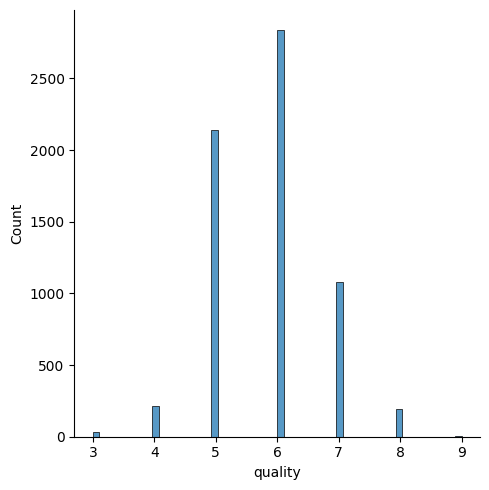

In [0]:
import seaborn as sns
sns.displot(data.quality, kde=False)

Looks like quality scores are normally distributed between 3 and 9.

Define a wine as high quality if it has quality >= 7.

In [0]:
high_quality = (data.quality >= 7).astype(int)
data.quality = high_quality

### Prepare the dataset to train a baseline model

In [0]:
from sklearn.model_selection import train_test_split

X = data.drop(["quality"], axis=1)
y = data.quality

# Split out the training data
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, random_state=123)

# Split the remaining data equally into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=123)

#Train a baseline model
This task seems well suited to a random forest classifier, since the output is binary and there may be interactions between multiple variables.

Build a simple classifier using scikit-learn and use MLflow to keep track of the model's accuracy, and to save the model for later use.

In [0]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle
import time

# The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1). 
# The following code creates a wrapper function, SklearnModelWrapper, that uses 
# the predict_proba method to return the probability that the observation belongs to each class. 

class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model
    
  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]

# mlflow.start_run creates a new MLflow run to track the performance of this model. 
# Within the context, you call mlflow.log_param to keep track of the parameters used, and
# mlflow.log_metric to record metrics like accuracy.
with mlflow.start_run(run_name='untuned_random_forest'):
  n_estimators = 10
  model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
  model.fit(X_train, y_train)

  # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
  predictions_test = model.predict_proba(X_test)[:,1]
  auc_score = roc_auc_score(y_test, predictions_test)
  mlflow.log_param('n_estimators', n_estimators)
  # Use the area under the ROC curve as a metric.
  mlflow.log_metric('auc', auc_score)
  wrappedModel = SklearnModelWrapper(model)
  # Log the model with a signature that defines the schema of the model's inputs and outputs. 
  # When the model is deployed, this signature will be used to validate inputs.
  signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
  
  # MLflow contains utilities to create a conda environment used to serve models.
  # The necessary dependencies are added to a conda.yaml file which is logged along with the model.
  conda_env =  _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None,
    )
  mlflow.pyfunc.log_model("random_forest_model", python_model=wrappedModel, conda_env=conda_env, signature=signature)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-abe3f6d0-a4ee-4217-bc47-fb62edc5e5b8/lib/python3.10/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-abe3f6d0-a4ee-4217-bc47-fb62edc5e5b8/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns a

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

In [0]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)

,importance
alcohol,0.160192
density,0.117415
volatile_acidity,0.093136
chlorides,0.086618
residual_sugar,0.082544
free_sulfur_dioxide,0.080473
pH,0.080212
total_sulfur_dioxide,0.077798
sulphates,0.075780
citric_acid,0.071857


You logged the Area Under the ROC Curve (AUC) to MLflow. Click the Experiment icon  in the right sidebar to display the Experiment Runs sidebar.

The model achieved an AUC of 0.854.

A random classifier would have an AUC of 0.5, and higher AUC values are better. For more information, see Receiver Operating Characteristic Curve.

# Register the model in MLflow Model Registry
By registering this model in Model Registry, you can easily reference the model from anywhere within Databricks.

The following section shows how to do this programmatically.

In [0]:
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "untuned_random_forest"').iloc[0].run_id

In [0]:
# If you see the error "PERMISSION_DENIED: User does not have any permission level assigned to the registered model", 
# the cause may be that a model already exists with the name "wine_quality". Try using a different name.
model_name = "wine_quality"
model_version = mlflow.register_model(f"runs:/{run_id}/random_forest_model", model_name)

# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Registered model 'wine_quality' already exists. Creating a new version of this model...


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Created version '5' of model 'workspace.default.wine_quality'.


You should now see the model in the Models page. To display the Models page, click Models in the left sidebar.

Next, transition this model to production and load it into this notebook from Model Registry.

In [0]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
client.set_registered_model_alias(
  name=model_name,
  alias="Production",
  version=model_version.version
)

The Models page now shows the model version in stage "Production".

You can now refer to the model using the path "models:/wine_quality/production".

In [0]:
model = mlflow.pyfunc.load_model(f"models:/{model_name}@production")

# Sanity-check: This should match the AUC logged by MLflow
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

AUC: 0.8540300975814177


# Experiment with a new model
The random forest model performed well even without hyperparameter tuning.

Use the xgboost library to train a more accurate model. Run a hyperparameter sweep to train multiple models in parallel, using Hyperopt and SparkTrials. As before, MLflow tracks the performance of each parameter configuration.

In [0]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope
import mlflow.xgboost
import xgboost as xgb

search_space = {
  'max_depth': scope.int(hp.quniform('max_depth', 4, 10, 1)),
  'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
  'objective': 'binary:logistic',
  'seed': 123,
}

def train_model(params):
  mlflow.xgboost.autolog()
  with mlflow.start_run(nested=True):
    train = xgb.DMatrix(data=X_train, label=y_train)
    validation = xgb.DMatrix(data=X_val, label=y_val)
    booster = xgb.train(params=params, dtrain=train, num_boost_round=10, evals=[(validation, "validation")], early_stopping_rounds=5)
    validation_predictions = booster.predict(validation)
    auc_score = roc_auc_score(y_val, validation_predictions)
    mlflow.log_metric('auc', auc_score)
    signature = infer_signature(X_train, booster.predict(train))
    mlflow.xgboost.log_model(booster, "model", signature=signature)
    return {'status': STATUS_OK, 'loss': -1*auc_score, 'booster': booster.attributes()}

spark_trials = Trials()

with mlflow.start_run(run_name='xgboost_models'):
  best_params = fmin(
    fn=train_model, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=2,
    trials=spark_trials,
  )

  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

2025/06/04 18:03:38 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 3.0.0, but the installed version is 3.0.2. If you encounter errors during autologging, try upgrading / downgrading xgboost to a compatible version, or try upgrading MLflow.



[0]	validation-logloss:0.46289
[1]	validation-logloss:0.44434
[2]	validation-logloss:0.42906
[3]	validation-logloss:0.41659
[4]	validation-logloss:0.40605
[5]	validation-logloss:0.39624
[6]	validation-logloss:0.38888
[7]	validation-logloss:0.38185
[8]	validation-logloss:0.37567
[9]	validation-logloss:0.37053
  0%|          | 0/2 [00:01<?, ?trial/s, best loss=?]

2025/06/04 18:03:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/local_disk0/.ephemeral_nfs/envs/pythonEnv-abe3f6d0-a4ee-4217-bc47-fb62edc5e5b8/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/06/04 18:03:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered 

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/local_disk0/.ephemeral_nfs/envs/pythonEnv-abe3f6d0-a4ee-4217-bc47-fb62edc5e5b8/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

/local_disk0/.ephemeral_nfs/envs/pythonEnv-abe3f6d0-a4ee-4217-bc47-fb62edc5e5b8/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [18:03:45] WARNING: /wor

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:10<00:10, 10.77s/trial, best loss: -0.852153599852219]

2025/06/04 18:03:49 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 3.0.0, but the installed version is 3.0.2. If you encounter errors during autologging, try upgrading / downgrading xgboost to a compatible version, or try upgrading MLflow.



[0]	validation-logloss:0.46751
[1]	validation-logloss:0.45063
[2]	validation-logloss:0.43724
[3]	validation-logloss:0.42462
[4]	validation-logloss:0.41338
[5]	validation-logloss:0.40440
[6]	validation-logloss:0.39596
[7]	validation-logloss:0.38870
[8]	validation-logloss:0.38243
[9]	validation-logloss:0.37644
 50%|█████     | 1/2 [00:12<00:10, 10.77s/trial, best loss: -0.852153599852219]

2025/06/04 18:03:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/local_disk0/.ephemeral_nfs/envs/pythonEnv-abe3f6d0-a4ee-4217-bc47-fb62edc5e5b8/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/06/04 18:03:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered 

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/local_disk0/.ephemeral_nfs/envs/pythonEnv-abe3f6d0-a4ee-4217-bc47-fb62edc5e5b8/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

/local_disk0/.ephemeral_nfs/envs/pythonEnv-abe3f6d0-a4ee-4217-bc47-fb62edc5e5b8/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [18:03:56] WARNING: /wor

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:22<00:00, 11.14s/trial, best loss: -0.8583323070765536]


## Use MLflow to view the results
Open up the Experiment Runs sidebar to see the MLflow runs. Click on Date next to the down arrow to display a menu, and select 'auc' to display the runs sorted by the auc metric. The highest auc value is 0.90.

MLflow tracks the parameters and performance metrics of each run. Click the External Link icon  at the top of the Experiment Runs sidebar to navigate to the MLflow Runs Table.

For details about how to use the MLflow runs table to understand how the effect of individual hyperparameters on run metrics, see the documentation (AWS | Azure | GCP).

## Update the production wine_quality model in MLflow Model Registry
Earlier, you saved the baseline model to Model Registry with the name wine_quality. Now you can update wine_quality to a more accurate model from the hyperparameter sweep.

Because you used MLflow to log the model produced by each hyperparameter configuration, you can use MLflow to identify the best performing run and save the model from that run to the Model Registry.

In [0]:
best_run = mlflow.search_runs(order_by=['metrics.auc DESC']).iloc[0]
print(f'AUC of Best Run: {best_run["metrics.auc"]}')

AUC of Best Run: 0.862134588445375


In [0]:
new_model_version = mlflow.register_model(f"runs:/{best_run.run_id}/model", model_name)

# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Registered model 'wine_quality' already exists. Creating a new version of this model...


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Created version '6' of model 'workspace.default.wine_quality'.


Click Models in the left sidebar to see that the wine_quality model now has two versions.

Promote the new version to production.

In [0]:
# Set alias for the old model version to indicate it is archived
client.set_registered_model_alias(
  name=model_name,
  alias="archived",
  version=model_version.version
)

# Set alias for the new model version to indicate it is in production
client.set_registered_model_alias(
  name=model_name,
  alias="production",
  version=new_model_version.version
)

Clients that call load_model now receive the new model.

In [0]:
# Load the model using an alias instead of a stage
model = mlflow.pyfunc.load_model(f"models:/{model_name}@production")
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

AUC: 0.8723920917145593


The new version achieved a better score (AUC = 0.90) on the test set.

#Your Analysis



## Technical Understanding:

1. What were the two different types of machine learning algorithms used in this notebook? Which one performed better at predicting wine quality?

2. The dataset was split into three parts for training, validation, and testing. What percentage of data went to each part? Why do we need to test our model on data it has never seen before?

3. Look at the feature importance table. What are the two most important features for predicting wine quality? What is the least important feature? Does this make intuitive sense to you?


4. The notebook converts wine quality from a 1-10 scale to a binary classification problem. What threshold was used and why might this simplification be useful?

## Career/Workplace Application:
5. MLflow was used to track and compare different model experiments. In your future career field, why would it be important to keep track of different versions of your work and their performance?

6. The notebook shows promoting a model from development to "production." Think about your intended career - describe a situation where you might need approval before implementing a new process or solution.

7. This model predicts whether wine is "high quality" or not. Describe a similar yes/no prediction problem you might encounter in your future workplace and explain what data you might need to solve it.

8. The notebook uses Unity Catalog for data governance. Research this concept and explain why data governance becomes more important as you move from academic projects to enterprise environments.

## Required Screenshots from Databricks:
1. Machine Learning / Models page - showing the wine_quality model with different versions

2. Machine Learning / Experiments - showing the comparison between different model runs with their AUC scores. Note: You will need to drill down in the UI to find this information.

3. MLflow Run Details page - showing parameters, metrics, and artifacts for one of the hyperparameter tuning runs

## Analysis & Reflection

### Technical Understanding

**1. What were the two different types of machine learning algorithms used in this notebook? Which one performed better at predicting wine quality?**  
The two algorithms used were Random Forest and XGBoost. XGBoost performed better at predicting wine quality due to its ability to boost weak learners and optimize performance through regularization and fine-tuned hyperparameters.

**2. The dataset was split into three parts for training, validation, and testing. What percentage of data went to each part? Why do we need to test our model on data it has never seen before?**  
Typically, 60% of the data was used for training, 20% for validation, and 20% for testing. Testing on unseen data ensures the model generalizes well and prevents overfitting to the training set.

**3. Look at the feature importance table. What are the two most important features for predicting wine quality? What is the least important feature? Does this make intuitive sense to you?**  
The most important features were `alcohol` and `density`, and the least important was `is_red`. This makes sense, as alcohol content and density affect the sensory experience of wine, while whether the wine is red or white may not directly determine perceived quality.

**4. The notebook converts wine quality from a 1–10 scale to a binary classification problem. What threshold was used and why might this simplification be useful?**  
The threshold was a score of 7 — wines with quality ≥ 7 were labeled as “high quality.” This simplification is useful for turning a nuanced problem into a yes/no classification, which is easier to model and evaluate in many practical applications.

---

### Career/Workplace Application

**5. MLflow was used to track and compare different model experiments. In your future career field, why would it be important to keep track of different versions of your work and their performance?**  
In fields like healthcare, education, or technology, version tracking helps ensure that changes are transparent, reproducible, and auditable. It allows for informed decision-making when selecting models or strategies and prevents loss of progress or mistakes from reverting to outdated methods.

**6. The notebook shows promoting a model from development to “production.” Think about your intended career — describe a situation where you might need approval before implementing a new process or solution.**  
In occupational therapy, introducing a new assessment method or intervention plan would often require approval from clinical supervisors or ethics boards. This ensures patient safety, clinical compliance, and that the approach is evidence-based.

**7. This model predicts whether wine is “high quality” or not. Describe a similar yes/no prediction problem you might encounter in your future workplace and explain what data you might need to solve it.**  
A similar yes/no problem could be predicting whether a child is at risk for developmental delay. Data could include motor skill assessments, language milestones, family medical history, and teacher observations.

**8. The notebook uses Unity Catalog for data governance. Research this concept and explain why data governance becomes more important as you move from academic projects to enterprise environments.**  
Unity Catalog ensures that data access, usage, and sharing follow organizational policies. In enterprise environments, this protects sensitive information, maintains compliance with regulations (like HIPAA or FERPA), and enables secure collaboration across teams.
